In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pip install opencv-python==3.3.0.10 opencv_contrib-python==3.3.0.10

     |████████████████████████████████| 15.5MB 208kB/s 
     |████████████████████████████████| 21.4MB 158kB/s 
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.3.0.10 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
import cv2
from sklearn.cluster import KMeans
import numpy as np
import glob
import os

# defining feature extractor that we want to use
extractor = cv2.xfeatures2d.SIFT_create()

def extract_features(image, extractor):
  keypoints, descriptors = extractor.detectAndCompute(image, None)
  return keypoints, descriptors


#Nous prenons le repertoire comme paramètre et chargeons les images
def load_images(folder_path):
  images, images_names = [], []
  for one_image in os.listdir(folder_path):
    image = cv2.imread(folder_path+one_image)
    images.append(image)          
    images_names.append(one_image)
    #return image read et leurs noms
  return images, images_names


#Extraction de tous les descripteurs dans la base d'images
#Avec les images lu et leur noms, nous procédons à l'extraction des descripteurs
def images_features(images, images_names):
  descriptors_list = []
  images_names_update = []
  idx = -1
  for image in images:
    # Convert them to grayscale
    idx+=1
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)        
    keypoint, descriptors = extract_features(image, extractor)
    #Verifié que le descripteur n'est pas nul avant de l'ajouter
    if (descriptors is not None):
      descriptors_list.append(descriptors)
      #Ici on s'assure que la liste des noms d'image est mise à jour
      #au cas ou l'extration n'a pas marché pour une image
      images_names_update.append(images_names[idx])

  #On retourne les descripturs et les noms d'images correspondant
  return descriptors_list, images_names_update


#converti une liste des descripteur d'images en un array numpy
#L'objectif est de pouvoir passer ce array au model de clustering
def list_descriptors_to_array_descriptor(descriptors_list):
  size=0
  for descriptors in descriptors_list:
    size+=descriptors.shape[0]

  descriptors_all = np.zeros((size, 128))
  i=0
  for descriptors in descriptors_list:
    for one_descriptor in descriptors:
      descriptors_all[i]=one_descriptor
      i+=1

  #On retourne ce array
  return descriptors_all


#Génération du modele kmeans de tous les descripteurs des images dans la base
#Ces images sont représenté par leurs descripteurs qu'on donne en parametre
def train_kmeans(all_images_descriptors, num_cluster):
  kmeans = KMeans(n_clusters = num_cluster)
  kmeans.fit(all_images_descriptors)
  return kmeans



#function de construction d'histogramme d'une image 
#(descriptors est la liste des descripteurs de l'image)
#return l'histogramme de l'image
def build_histogram(clustering_model, descriptors):
  hist = np.zeros(clustering_model.cluster_centers_.shape[0])
  n_desc = np.size(descriptors)
  for desc in descriptors:
    #Pour chaque descripteur, on prédit à quel sac de mot visuel il appartient
    idx = clustering_model.predict([desc])
    #On ajoute à l'index du sac de mot 1/nombre de descripteur car il faut normalisé l'histogramme
    hist[idx] += 1/n_desc
  
  #On retourne l'histogram de l'image
  return hist


#Calcul de l'histogramme de toutes les images
#(imgs_descriptors_list est la liste des descripteurs de toutes les images dans la base)
def build_all_images_histogram(clustering_model, imgs_descriptors_list):
  histograms=[]
  for descriptors in imgs_descriptors_list:
    hist = build_histogram(clustering_model, descriptors)
    histograms.append(hist)

  #histograms = np.asarray(histograms)
  #retourne les array des histogrammes
  return histograms



In [0]:
img_path = 'drive/My Drive/Colab Notebooks/Datasets/image_orig/'

def Indexation(num_cluster=75):
  #charger les images
  num_cluster = num_cluster
  images, images_names = load_images(img_path)
  #print(images_names)
  print("End load images")
  #recupération des descripteurs dans les images
  descriptors_list, images_names_descriptors  = images_features(images, images_names)
  print("End extract descriptors")
  #conversion en un numpy array
  descriptors_np = list_descriptors_to_array_descriptor(descriptors_list)
  print("End conversion")
  #Génération du modele kmeans
  clustering_model = train_kmeans(descriptors_np, num_cluster)
  print("End clustering")
  #Construction de l'histograme
  images_histograms = build_all_images_histogram(clustering_model, descriptors_list)
  print("End build histogram")

  #On sauvegarde le modele, les histogrames et les noms des images pour une utilisation ultérieur
  save_path = 'drive/My Drive/Colab Notebooks/Datasets/'

  import pickle
  with open(save_path+'images_histograms4.hist', 'wb') as handle:
      pickle.dump(images_histograms, handle)

  with open(save_path+'clustering_model4.md', 'wb') as handle:
      pickle.dump(clustering_model, handle)

  with open(save_path+'images_names4.names', 'wb') as handle:
      pickle.dump(images_names_descriptors, handle)

  print("End funct indexation")

  return images_histograms, clustering_model, images_names_descriptors


In [0]:
images_histograms, clustering_model, images_names_descriptors = Indexation()

End load images
End extract descriptors
End conversion
End clustering
End build histogram
End funct indexation


In [0]:
folder_path = 'drive/My Drive/Colab Notebooks/Datasets/image_orig/'

from sklearn.neighbors import NearestNeighbors

#Grace au modele et histograme que nous avons contruit,nous pouvons rechercher 
#les images les plus proches en calculant l'histograme de la nouvelle image puis
#recherchons les plus proches histograms
def recherche(image_path, N=10, distance='minkowski'):
  #Lecture et extraction des descripteurs de l'image
  new_image = cv2.imread(image_path)
  new_image = cv2.cvtColor(new_image,cv2.COLOR_BGR2GRAY)        
  keypoint, descriptor = extract_features(new_image, extractor)
  #Construction de l'histogram de la nouvelle image
  img_hist = build_histogram(clustering_model, descriptor)
  #Entrainement des anciens histogram sur un model de knn
  neighbor = NearestNeighbors(n_neighbors = N, metric=distance)
  neighbor.fit(images_histograms)
  #Recherche des plus proches histogram à la nouvelle image
  dist, results = neighbor.kneighbors([img_hist])
  #Transformation en un vecteur
  results = np.squeeze(np.asarray(results))
  #return les noms des image mapper aux références du resulat de knn
  return list(map(lambda x: images_names_descriptors[int(x)], results))


#Cette fonction prend en parametre deux noms d'image et vérifi 
#s'il sont du meme concept ou pas
def isInSameConcept(name_image1, name_image2):
  return ((abs(int(name_image1[:-4]) - (int(name_image2[:-4])))) < 100)


#Calcul de la précision d'une image donné en parametre
def precision_image(image_path):
  #recherche des images similaire
  nearest_images = recherche(image_path, N=10, distance='minkowski')
  name_ref_image = image_path.split('/')[-1]
  nb_img_same_concept = 0
  #Pour chaque image dans les image similaire, on compare le concept de l'image de 
  #reférence au concept de l'image similaire s'ils sont identique, on augmente la precision
  for one_image in nearest_images:
    if(isInSameConcept(name_ref_image, one_image)):
      nb_img_same_concept +=1

  #On retourne la précion
  return (nb_img_same_concept/len(nearest_images))


#fonction de recherche d'un concept à partir du numéro d'image
def image_concept(numero_image):
  if(numero_image < 100):
    return 0
  elif (numero_image >= 100 and numero_image < 200 ):
    return 1
  elif (numero_image >= 200 and numero_image < 300 ):
    return 2
  elif (numero_image >= 300 and numero_image < 400 ):
    return 3
  elif (numero_image >= 400 and numero_image < 500 ):
    return 4
  elif (numero_image >= 500 and numero_image < 600 ):
    return 5
  elif (numero_image >= 600 and numero_image < 700 ):
    return 6
  elif (numero_image >= 700 and numero_image < 800 ):
    return 7
  elif (numero_image >= 800 and numero_image < 900 ):
    return 8
  else:
    return 9


#Fonction de calcul de la précision du system
#return precision system
def AnalyseResultats():
  precisions = []
  for one_image in os.listdir(folder_path):
    #Calculer la précision pour chaque image
    precision = precision_image(folder_path+one_image)
    precisions.append(precision)
  #Faire la moyenne des precision
  system_precision = np.mean(precisions)

  return system_precision


In [0]:
#variation du nombre de clusters
num_clusters = [50, 75, 100, 200, 300, 400, 500]
list_precisions_system = []
best_num_cluster = 0
best_precision_system = 0
for num_cluster in num_clusters:
  list_precisions = []
  #Pour chaque nombre de cluster, faire l'indexation
  images_histograms, clustering_model, images_names_descriptors = Indexation(num_cluster)
  for k in range(10):
    concept_precision = precision_by_concept(k)
    list_precisions.append(concept_precision)
  
  list_precisions_system.append(np.mean(list_precisions))
  #Si la nouvelle précision est meilleure, on la garde.
  if(list_precisions_system[-1] > best_precision_system):
    best_num_cluster = num_cluster
    best_precision_system = list_precisions_system[-1]

  print('Précision systeme pour '+(str(num_cluster))+' clusters = %.5f ' % (list_precisions_system[-1]))

print('Le meilleure nombre de clusters est '+(str(best_num_cluster))+' avec une précision systeme de  %.5f ' % (best_precision_system))


End load images
End extract descriptors
End conversion
End clustering
End build histogram
End funct indexation
Précision systeme pour 50 clusters = 0.55890 
End load images
End extract descriptors
End conversion
End clustering
End build histogram
End funct indexation
Précision systeme pour 75 clusters = 0.56520 
End load images
End extract descriptors
End conversion
End clustering
End build histogram
End funct indexation
Précision systeme pour 100 clusters = 0.56130 
End load images
End extract descriptors
End conversion
End clustering
End build histogram
End funct indexation
Précision systeme pour 200 clusters = 0.54010 
End load images
End extract descriptors
End conversion
End clustering
End build histogram
End funct indexation
Précision systeme pour 300 clusters = 0.52930 
End load images
End extract descriptors
End conversion
End clustering
End build histogram
End funct indexation
Précision systeme pour 400 clusters = 0.50400 
End load images
End extract descriptors
End conversion

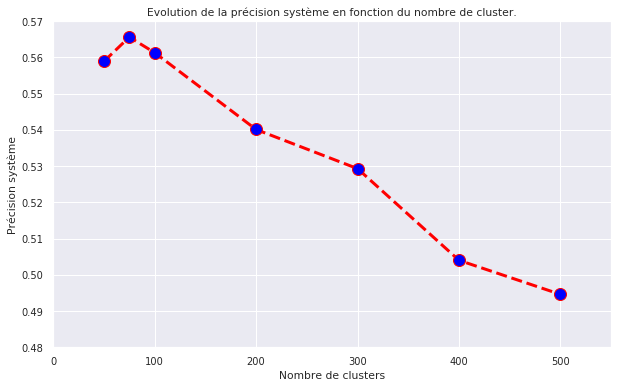

In [0]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))# taille de la figure
# plotting the points  
plt.plot(num_clusters, list_precisions_system, color='red', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
# setting x and y axis range 
plt.ylim(0.48,0.57) 
plt.xlim(0,550) 
plt.xlabel('Nombre de clusters') 
plt.ylabel('Précision système') 
plt.title('Evolution de la précision système en fonction du nombre de cluster.')
plt.show() 


In [0]:
sys_precision = AnalyseResultats()
print('Analase des résulats donne une précision systeme = %.5f ' % (sys_precision))

Analase des résulats donne une précision systeme = 0.56520 


In [0]:
from sklearn.metrics import confusion_matrix


def search_image_by_concept(concept):
  images_path_list = []
  max_img = (concept+1)*100
  for i in range(max_img-100, max_img):
    images_path_list.append(str(i)+'.jpg')

  return images_path_list

#Prends un concept et renvoi la précision de cette derniere
def precision_by_concept(concept):
  precisions = []
  images_path_list = search_image_by_concept(concept)
  for one_image in images_path_list:
    precision = precision_image(folder_path+one_image)
    precisions.append(precision)
    
  concept_precision = np.mean(precisions)

  return concept_precision


#Calcul la matrice de confusion du système
def confusion_matrice_by_concept():
  precisions = []
  imgs_true = []
  imgs_pred = []
  for one_image in os.listdir(folder_path):
    concept_im1 = image_concept(int(one_image[:-4]))
    #recherche des image similaire
    nearest_images = recherche(folder_path+one_image, N=10, distance='minkowski')
    for one_near_image in nearest_images:
      #prendre le concept auquel appartient l'image 1 et l'image2
      concept_im2 = image_concept(int(one_near_image[:-4]))
      imgs_true.append(concept_im1)
      imgs_pred.append(concept_im2)
  
  #Génération de la matrice de cofusion grace aux images réélle et au prédictions
  conf_matrix = confusion_matrix(imgs_true, imgs_pred)
  return conf_matrix


In [0]:
#Calcul de la précision par concept
list_precisions = []
for k in range(10):
  concept_precision = precision_by_concept(k)
  list_precisions.append(concept_precision)

for k in range(10):
  print('Concept: '+(str(k))+':  a une precision de: %.5f ' % (list_precisions[k]))

print('Précision systeme = %.5f ' % (np.mean(list_precisions)))

Concept: 0:  a une precision de: 0.53800 
Concept: 1:  a une precision de: 0.32600 
Concept: 2:  a une precision de: 0.46700 
Concept: 3:  a une precision de: 0.81600 
Concept: 4:  a une precision de: 0.88300 
Concept: 5:  a une precision de: 0.61600 
Concept: 6:  a une precision de: 0.47400 
Concept: 7:  a une precision de: 0.70000 
Concept: 8:  a une precision de: 0.40200 
Concept: 9:  a une precision de: 0.43000 
Précision systeme = 0.56520 


In [0]:
conf_mat = confusion_matrice_by_concept()
conf_mat

array([[527,  36,  74,  24,   1,  64,   5,  25,  59, 185],
       [ 98, 218, 127,  29,  15, 204,  15,  89,  91, 114],
       [105,  64, 402,  49,  12, 150,  10,  25,  60, 123],
       [ 58,  10,  72, 774,   1,   6,   0,  22,  15,  42],
       [  9,  31,  23,   3, 839,  73,   1,   2,   9,  10],
       [ 56,  54,  58,   3,   3, 615,   2,  91,  34,  84],
       [145,  42,  44,  26,   8, 112, 417,   4,  88, 114],
       [ 66,  21,  33,  38,   0,  92,   1, 688,  45,  16],
       [183,  72,  81,  20,   2,  96,  27,  59, 298, 162],
       [209,  41,  86,  30,   1, 144,   1,  21,  85, 382]])

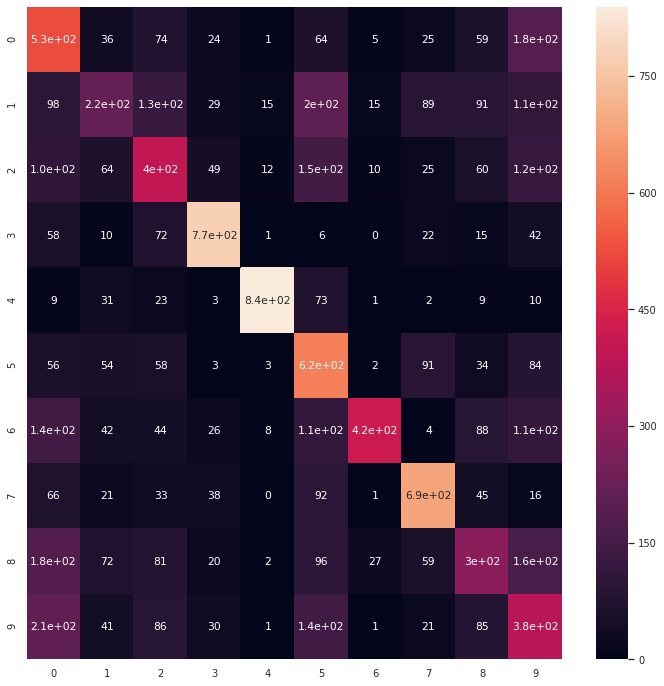

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

df_conf_matrix = pd.DataFrame(conf_mat, range(10), range(10))
plt.figure(figsize=(12,12))# taille de la figure
sn.set(font_scale=0.9) # for label size
sn.heatmap(df_conf_matrix, annot=True) # font size

plt.show()

## Deuxième partie

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Chargement du model de cluster, les hitogrames d'image et les noms d'images dumpé
save_path = 'drive/My Drive/Colab Notebooks/Datasets/'

import pickle

with open(save_path+'images_histograms4.hist', 'rb') as handle:
    images_histograms = pickle.load(handle)

with open(save_path+'clustering_model4.md', 'rb') as handle:
    clustering_model = pickle.load(handle)

with open(save_path+'images_names4.names', 'rb') as handle:
    images_names_descriptors = pickle.load(handle)

In [0]:
all_images_names = images_names_descriptors

# fonction de construction d'un dictionaire dont les clés sont les noms des images 
# et les valeurs les mots visuels
# arguments: liste des histogrames des images et liste des noms des images
# returns: dictionaire dont les clés sont les noms des images et les valeurs les mots visuels
def build_dict_imageName_motVisuels(list_histograms, images_names):
  dict_imageName_motVisuels = {} #dictionaire dont les clés sont les noms des images et les valeurs les mots visuels
  for i in range(len(list_histograms)):#Boucle sur tous les histogrames des images
    #Pour chaque histograme d'image on recupére un vecteur de True or False
    #indiquant si oui le mot visuel exite ou pas dans l'image
    all_positive_freq = list_histograms[i]>0
    all_words_in_image = [] #List qui contiendra des mots visuel d'une image
    for h in range(len(all_positive_freq)):
      if all_positive_freq[h] == True:#Si True alors le mot visuel est dans l'image
        all_words_in_image.append(h)
    
    dict_imageName_motVisuels[images_names[i]] = all_words_in_image

  return dict_imageName_motVisuels



# fonction de construction du fichier inversé 
# et les valeurs les mots visuels
# arguments: dictionaire dont les clés sont les mots visuels et valeurs sont les noms des images
# et liste des mots visuels
# returns: fichier inversé qui est un dictionaire dont les clés sont les mots visuels et les valeurs sont les noms des images

def make_invert_file(dict_imageName_motVisuels, words):
  dict_motVisuel_imageNames = {word:set(image_name
                        for image_name, wrds in dict_imageName_motVisuels.items() if word in wrds)
            for word in words}            
  return dict_motVisuel_imageNames



# fonction de Recherche des images contenant les mots visuels données en paramètre dans le fichier inversé
# arguments: dictionaire dont les clés sont les mots visuels  et les valeurs les noms des images
# et liste des mots visuels(words)
# returns: liste des images contenant les mots visuel passé en parametres
def search_images_names_by_words(dict_motVisuel_imageNames, words):
  list_images = list()
  for word in words:
    #Pour chaque mot visuel on récupère les images concernés
    list_images = list_images+list(dict_motVisuel_imageNames.get(word)) #on ajoute à la liste
  
  #On retourne le set de la liste des images pour éviter les doublons
  return  list(set(list_images))


#Fonction de recherche des histogrames des images grâce au nom de ces dernères
#parameters: liste des histogrammes de tous les images, liste des noms de tous les images, 
#liste des noms des images dont-on veut cherher l'histogramme chercher
#return la liste des histogrammes des images correspondant
def search_histograms_by_image_names(images_search_name, histograms_all_image, images_all_names):
  histo_find = []
  #récupérer les index des documents
  for image_search_name in images_search_name:
    #recupérer l'index de l'image
    idx = images_all_names.index(image_search_name)
    #recupération de l'histogram
    histo = histograms_all_image[idx]
    histo_find.append(histo)
  
  return histo_find



#Récupération de tous les mots visuels
allwords = list(set(clustering_model.labels_))

#Construction du dictionaire dont les clés sont les noms des images et les valeurs les mots visuels
dict_imageName_motVisuels = build_dict_imageName_motVisuels(images_histograms, all_images_names)

#Construction du fichier inversé
#C'est un dictionnaire dont les clés sont les mots visuels
#Et les valeurs sont les noms des images
dict_motVisuel_imageNames = make_invert_file(dict_imageName_motVisuels, allwords)



#Elle est une modification de la fonction de recherche de la premiere partie
#Return la liste des images similaire a l'image donné en parametre
def rechercher_image_similaire(image_path, N=10, distance='minkowski'):
  #Lecture et extraction des descripteurs de l'image
  new_image = cv2.imread(image_path)
  new_image = cv2.cvtColor(new_image,cv2.COLOR_BGR2GRAY)        
  keypoint, descriptors = extract_features(new_image, extractor)
  #Construction de l'histogram de la nouvelle image
  img_hist = build_histogram(clustering_model, descriptors)

  all_positive_freq = img_hist>0
  all_words_in_image = [] #list qui contiendra des mots visuel de l'image
  for h in range(len(all_positive_freq)):
    if all_positive_freq[h] == True:#Si True alors le mot visuel est dans l'image
      all_words_in_image.append(h)
  
  images_name_with_same_words = search_images_names_by_words(dict_motVisuel_imageNames, all_words_in_image)

  histo_images_name_with_same_words = search_histograms_by_image_names(images_name_with_same_words, 
                                                                       images_histograms, all_images_names)

  #Entrainement du model knn sur uniquement les histogrammes d'images ayant les mots visuels commun
  neighbor = NearestNeighbors(n_neighbors = N, metric=distance)
  neighbor.fit(histo_images_name_with_same_words)
  #Recherche des plus proches histogram à la nouvelle image
  dist, results = neighbor.kneighbors([img_hist])
  #Transformation en un vecteur
  results = np.squeeze(np.asarray(results))
  #return les noms des image mapper aux références du resulat de knn
  return list(map(lambda x: all_images_names[int(x)], results))




In [0]:
folder_path = 'drive/My Drive/Colab Notebooks/Datasets/image_orig/'

from sklearn.neighbors import NearestNeighbors


#Calcul de la précision d'une image donné en parametre
def precision_image_by_invert_search(image_path):
  #recherche des images similaire
  nearest_images = rechercher_image_similaire(image_path, N=10, distance='minkowski')
  name_ref_image = image_path.split('/')[-1]
  nb_img_same_concept = 0
  #Pour chaque image dans les image similaire, on compare le concept de l'image de 
  #reférence au concept de l'image similaire s'ils sont identique, on augmente la precision
  for one_image in nearest_images:
    if(isInSameConcept(name_ref_image, one_image)):
      nb_img_same_concept +=1

  #On retourne la précion
  return (nb_img_same_concept/len(nearest_images))


def AnalyseResultats_invert_search():
  precisions = []
  for one_image in os.listdir(folder_path):
    precision = precision_image_by_invert_search(folder_path+one_image)
    precisions.append(precision)
  
  system_precision = np.mean(precisions)

  return system_precision


In [0]:
sys_precision_inv_file = AnalyseResultats_invert_search()
print('Résultats pour le fichier inversé')
print('Analyse des résulats donne une précision systeme = %.5f ' % (sys_precision_inv_file))

Résultats pour le fichier inversé
Analyse des résulats donne une précision systeme = 0.18860 


In [0]:
#End